In [1]:
# python native
import os
import json
import random
import datetime
from functools import partial

# external library
import cv2
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn.model_selection import GroupKFold

# visualization
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [24]:
import torch

In [2]:
IMAGE_ROOT = "./data/train/DCM"
LABEL_ROOT = "./data/train/outputs_json"

In [3]:
CLASSES = [
    'finger-1', 'finger-2', 'finger-3', 'finger-4', 'finger-5',
    'finger-6', 'finger-7', 'finger-8', 'finger-9', 'finger-10',
    'finger-11', 'finger-12', 'finger-13', 'finger-14', 'finger-15',
    'finger-16', 'finger-17', 'finger-18', 'finger-19', 'Trapezium',
    'Trapezoid', 'Capitate', 'Hamate', 'Scaphoid', 'Lunate',
    'Triquetrum', 'Pisiform', 'Radius', 'Ulna',
]
CLASS2IND = {v: i for i, v in enumerate(CLASSES)}
IND2CLASS = {v: k for k, v in CLASS2IND.items()}

In [4]:
pngs = {
    os.path.relpath(os.path.join(root, fname), start=IMAGE_ROOT)
    for root, _dirs, files in os.walk(IMAGE_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".png"
}

jsons = {
    os.path.relpath(os.path.join(root, fname), start=LABEL_ROOT)
    for root, _dirs, files in os.walk(LABEL_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".json"
}

In [54]:
print(len(pngs))
print(len(jsons))

800
800


In [55]:
df = pd.read_csv('validation_output.csv')

In [81]:
df

image_name       class  \
0     image1661130828152_R.png    finger-1   
1     image1661130828152_R.png    finger-2   
2     image1661130828152_R.png    finger-3   
3     image1661130828152_R.png    finger-4   
4     image1661130828152_R.png    finger-5   
...                        ...         ...   
4635    image1667350422279.png      Lunate   
4636    image1667350422279.png  Triquetrum   
4637    image1667350422279.png    Pisiform   
4638    image1667350422279.png      Radius   
4639    image1667350422279.png        Ulna   

                                                    rle  \
0     1456605 7 1458650 12 1460696 16 1462742 20 146...   
1     1698359 3 1700402 12 1702446 18 1704492 22 170...   
2     2087597 7 2089644 14 2091691 17 2093738 19 209...   
3     471787 6 473833 12 475878 19 477924 23 479970 ...   
4     686862 5 688901 15 690946 19 692991 23 695036 ...   
...                                                 ...   
4635  2974645 12 2976688 21 2978733 26 2980779 30 29...   
4636  2911045 2 2913088 10 2915133 15 2917179 19 291...   
4637  2943826 1 2945867 13 2947911 19 2949956 25 295...   
4638  2991173 10 2993219 16 2995266 18 2997312 21 29...   
4639  3205943 6 3207989 10 3210036 12 3212082 15 321...   

                          image_path                       label_path  
0     ID001/image1661130828152_R.png  ID001/image1661130828152_R.json  
1     ID001/image1661130828152_R.png  ID001/image1661130828152_R.json  
2     ID001/image1661130828152_R.png  ID001/image1661130828152_R.json  
3     ID001/image1661130828152_R.png  ID001/image1661130828152_R.json  
4     ID001/image1661130828152_R.png  ID001/image1661130828152_R.json  
...                              ...                              ...  
4635    ID544/image1667350422279.png    ID544/image1667350422279.json  
4636    ID544/image1667350422279.png    ID544/image1667350422279.json  
4637    ID544/image1667350422279.png    ID544/image1667350422279.json  
4638    ID544/image1667350422279.png    ID544/image1667350422279.json  
4639    ID544/image1667350422279.png    ID544/image1667350422279.json  

[4640 rows x 5 columns]

In [56]:
list(pngs)[1].split("/")[1]

'image1666747096906.png'

In [57]:
image_dict = {name.split("/")[1]:name for name in list(pngs)}
label_dict = {name.split("/")[1][:-4]+'png':name for name in list(jsons)}

In [83]:
image_dict

{'image1664933074279.png': 'ID346/image1664933074279.png',
 'image1666747096906.png': 'ID506/image1666747096906.png',
 'image1661390896968.png': 'ID052/image1661390896968.png',
 'image1664157343885.png': 'ID293/image1664157343885.png',
 'image1661738545281.png': 'ID086/image1661738545281.png',
 'image1666057227282.png': 'ID421/image1666057227282.png',
 'image1666142946835.png': 'ID442/image1666142946835.png',
 'image1666748279898.png': 'ID514/image1666748279898.png',
 'image1665540873549.png': 'ID408/image1665540873549.png',
 'image1661216788592.png': 'ID013/image1661216788592.png',
 'image1666746533895.png': 'ID500/image1666746533895.png',
 'image1667265417194.png': 'ID534/image1667265417194.png',
 'image1666747005566.png': 'ID505/image1666747005566.png',
 'image1667178762956.png': 'ID523/image1667178762956.png',
 'image1666661971614.png': 'ID487/image1666661971614.png',
 'image1664847331497.png': 'ID332/image1664847331497.png',
 'image1664933852344.png': 'ID350/image1664933852344.png

In [82]:
pngs

{'ID001/image1661130828152_R.png',
 'ID001/image1661130891365_L.png',
 'ID002/image1661144206667.png',
 'ID002/image1661144246917.png',
 'ID003/image1661144310162.png',
 'ID003/image1661144351691.png',
 'ID004/image1661144691792.png',
 'ID004/image1661144724044.png',
 'ID005/image1661144825412.png',
 'ID005/image1661144852117.png',
 'ID006/image1661145075929.png',
 'ID006/image1661145103549.png',
 'ID007/image1661145193855.png',
 'ID007/image1661145229731.png',
 'ID008/image1661145286692.png',
 'ID008/image1661145313061.png',
 'ID009/image1661145407161.png',
 'ID009/image1661145432967.png',
 'ID010/image1661145563354.png',
 'ID010/image1661145591320.png',
 'ID011/image1661146664360.png',
 'ID011/image1661146685158.png',
 'ID012/image1661147072358.png',
 'ID012/image1661147098202.png',
 'ID013/image1661216747360.png',
 'ID013/image1661216788592.png',
 'ID014/image1661216876670.png',
 'ID014/image1661216907060.png',
 'ID015/image1661216971933.png',
 'ID015/image1661216998230.png',
 'ID01

In [58]:
df["image_path"] = df['image_name'].apply(lambda x: image_dict[x])

In [84]:
df

image_name       class  \
0     image1661130828152_R.png    finger-1   
1     image1661130828152_R.png    finger-2   
2     image1661130828152_R.png    finger-3   
3     image1661130828152_R.png    finger-4   
4     image1661130828152_R.png    finger-5   
...                        ...         ...   
4635    image1667350422279.png      Lunate   
4636    image1667350422279.png  Triquetrum   
4637    image1667350422279.png    Pisiform   
4638    image1667350422279.png      Radius   
4639    image1667350422279.png        Ulna   

                                                    rle  \
0     1456605 7 1458650 12 1460696 16 1462742 20 146...   
1     1698359 3 1700402 12 1702446 18 1704492 22 170...   
2     2087597 7 2089644 14 2091691 17 2093738 19 209...   
3     471787 6 473833 12 475878 19 477924 23 479970 ...   
4     686862 5 688901 15 690946 19 692991 23 695036 ...   
...                                                 ...   
4635  2974645 12 2976688 21 2978733 26 2980779 30 29...   
4636  2911045 2 2913088 10 2915133 15 2917179 19 291...   
4637  2943826 1 2945867 13 2947911 19 2949956 25 295...   
4638  2991173 10 2993219 16 2995266 18 2997312 21 29...   
4639  3205943 6 3207989 10 3210036 12 3212082 15 321...   

                          image_path                       label_path  
0     ID001/image1661130828152_R.png  ID001/image1661130828152_R.json  
1     ID001/image1661130828152_R.png  ID001/image1661130828152_R.json  
2     ID001/image1661130828152_R.png  ID001/image1661130828152_R.json  
3     ID001/image1661130828152_R.png  ID001/image1661130828152_R.json  
4     ID001/image1661130828152_R.png  ID001/image1661130828152_R.json  
...                              ...                              ...  
4635    ID544/image1667350422279.png    ID544/image1667350422279.json  
4636    ID544/image1667350422279.png    ID544/image1667350422279.json  
4637    ID544/image1667350422279.png    ID544/image1667350422279.json  
4638    ID544/image1667350422279.png    ID544/image1667350422279.json  
4639    ID544/image1667350422279.png    ID544/image1667350422279.json  

[4640 rows x 5 columns]

In [59]:
df["label_path"] = df['image_name'].apply(lambda x: label_dict[x])

In [60]:
df['image_name'].iloc[1]

'image1661130828152_R.png'

In [61]:
def rle_to_mask(rle, height, width):
    mask = np.zeros(height * width, dtype=np.uint8)
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2] - 1
    lengths = array[1::2]
    for start, length in zip(starts, lengths):
        mask[start:start + length] = 1
    return mask.reshape((height, width))

In [ ]:
def mask_to_poly_seg(mask):
    points = np.argwhere(mask == 1)
    points = points[:, [1, 0]]  # (row, col) => (x, y)
    return points.tolist()

In [63]:
PALETTE = [
    (220, 20, 60), (119, 11, 32), (0, 0, 142), (0, 0, 230), (106, 0, 228),
    (0, 60, 100), (0, 80, 100), (0, 0, 70), (0, 0, 192), (250, 170, 30),
    (100, 170, 30), (220, 220, 0), (175, 116, 175), (250, 0, 30), (165, 42, 42),
    (255, 77, 255), (0, 226, 252), (182, 182, 255), (0, 82, 0), (120, 166, 157),
    (110, 76, 0), (174, 57, 255), (199, 100, 0), (72, 0, 118), (255, 179, 240),
    (0, 125, 92), (209, 0, 151), (188, 208, 182), (0, 220, 176),
]


In [64]:
def label2rgb(label):
    image_size = label.shape[1:] + (3, )
    image = np.zeros(image_size, dtype=np.uint8)
    
    for i, class_label in enumerate(label):
        image[class_label == 1] = PALETTE[i]
        
    return image

In [87]:
df

image_name       class  \
0     image1661130828152_R.png    finger-1   
1     image1661130828152_R.png    finger-2   
2     image1661130828152_R.png    finger-3   
3     image1661130828152_R.png    finger-4   
4     image1661130828152_R.png    finger-5   
...                        ...         ...   
4635    image1667350422279.png      Lunate   
4636    image1667350422279.png  Triquetrum   
4637    image1667350422279.png    Pisiform   
4638    image1667350422279.png      Radius   
4639    image1667350422279.png        Ulna   

                                                    rle  \
0     1456605 7 1458650 12 1460696 16 1462742 20 146...   
1     1698359 3 1700402 12 1702446 18 1704492 22 170...   
2     2087597 7 2089644 14 2091691 17 2093738 19 209...   
3     471787 6 473833 12 475878 19 477924 23 479970 ...   
4     686862 5 688901 15 690946 19 692991 23 695036 ...   
...                                                 ...   
4635  2974645 12 2976688 21 2978733 26 2980779 30 29...   
4636  2911045 2 2913088 10 2915133 15 2917179 19 291...   
4637  2943826 1 2945867 13 2947911 19 2949956 25 295...   
4638  2991173 10 2993219 16 2995266 18 2997312 21 29...   
4639  3205943 6 3207989 10 3210036 12 3212082 15 321...   

                          image_path                       label_path  
0     ID001/image1661130828152_R.png  ID001/image1661130828152_R.json  
1     ID001/image1661130828152_R.png  ID001/image1661130828152_R.json  
2     ID001/image1661130828152_R.png  ID001/image1661130828152_R.json  
3     ID001/image1661130828152_R.png  ID001/image1661130828152_R.json  
4     ID001/image1661130828152_R.png  ID001/image1661130828152_R.json  
...                              ...                              ...  
4635    ID544/image1667350422279.png    ID544/image1667350422279.json  
4636    ID544/image1667350422279.png    ID544/image1667350422279.json  
4637    ID544/image1667350422279.png    ID544/image1667350422279.json  
4638    ID544/image1667350422279.png    ID544/image1667350422279.json  
4639    ID544/image1667350422279.png    ID544/image1667350422279.json  

[4640 rows x 5 columns]

In [ ]:
def vis_val(df,idx):

    img_names = df['image_name'].unique()

    df_ = df[df['image_name']==img_names[idx]]

    image_path = df_['image_path'].iloc[0]
    
    image = cv2.imread(os.path.join(IMAGE_ROOT, image_path))
    image = image / 255.

    label_path = df_['label_path'].iloc[0]

    # (H, W, NC) 모양의 label을 생성합니다.
    label_shape = tuple(image.shape[:2]) + (len(CLASSES), )
    label = np.zeros(label_shape, dtype=np.uint8)

    # label 파일을 읽습니다.
    with open(os.path.join(LABEL_ROOT, label_path), "r") as f:
        annotations = json.load(f)
    annotations = annotations["annotations"]

    # 클래스 별로 처리합니다.
    for ann in annotations:
        c = ann["label"]
        class_ind = CLASS2IND[c]
        points = np.array(ann["points"])
        
        # polygon 포맷을 dense한 mask 포맷으로 바꿉니다.
        class_label = np.zeros(image.shape[:2], dtype=np.uint8)
        cv2.fillPoly(class_label, [points], 1)
        label[..., class_ind] = class_label

    # to tenser will be done later
    image = image.transpose(2, 0, 1)    # channel first 포맷으로 변경합니다.
    label = label.transpose(2, 0, 1)

    image = torch.from_numpy(image).float()
    label = torch.from_numpy(label).float()
    
    fig, ax = plt.subplots(1, 2, figsize=(24, 12))
    ax[0].imshow(image[0])    # color map 적용을 위해 channel 차원을 생략합니다.
    ax[1].imshow(label2rgb(label))

    plt.show()
    # return image, label

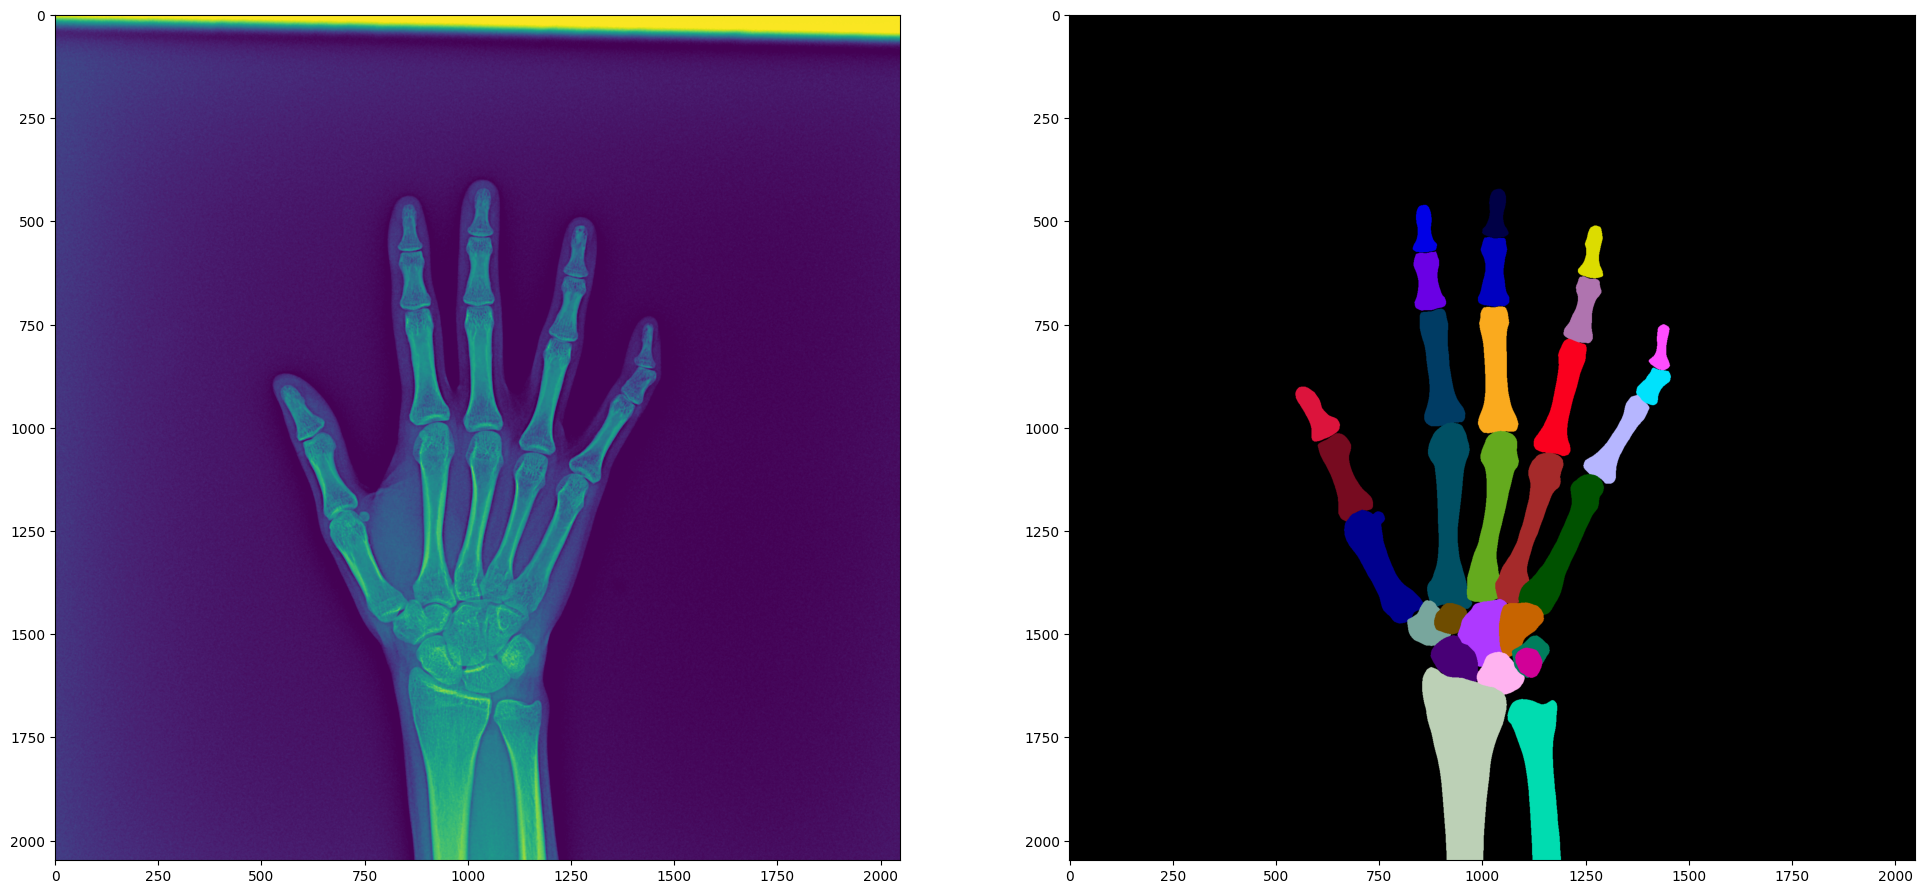

In [88]:
vis_val(df,2)

In [ ]:
def vis_val_pred(df,idx):

    img_names = df['image_name'].unique()

    df_ = df[df['image_name']==img_names[idx]]

    image_path = df_['image_path'].iloc[0]
    
    image = cv2.imread(os.path.join(IMAGE_ROOT, image_path))
    image = image / 255.


    # (H, W, NC) 모양의 label을 생성합니다.
    label_shape = tuple(image.shape[:2]) + (len(CLASSES), )
    label = np.zeros(label_shape, dtype=np.uint8)

    for index, row in df_.iterrows():
        rle = row['rle']
        class_ind = CLASS2IND[row['class']]
        mask = rle_to_mask(rle, 2048, 2048)
        label[..., class_ind] = mask


    # to tenser will be done later
    image = image.transpose(2, 0, 1)    # channel first 포맷으로 변경합니다.
    label = label.transpose(2, 0, 1)

    image = torch.from_numpy(image).float()
    label = torch.from_numpy(label).float()
    
    fig, ax = plt.subplots(1, 2, figsize=(24, 12))
    ax[0].imshow(image[0])    # color map 적용을 위해 channel 차원을 생략합니다.
    ax[1].imshow(label2rgb(label))

    plt.show()
    # return image, label

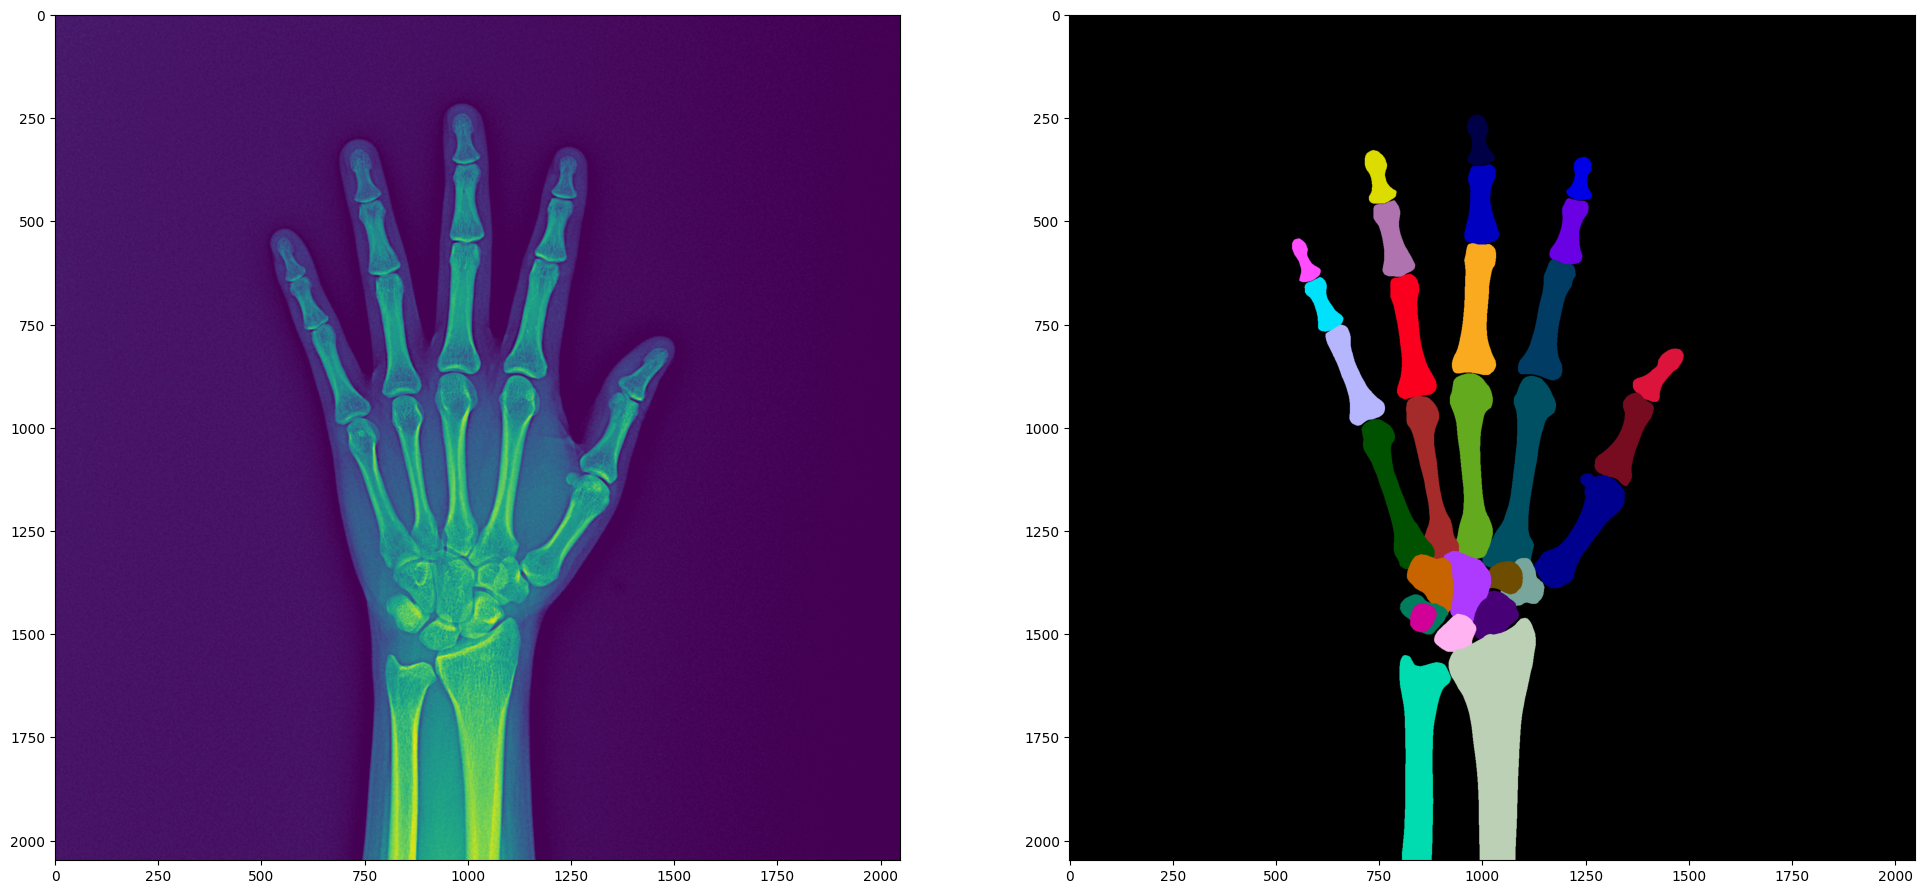

In [78]:
vis_val(df,1)

In [89]:
img_names = df['image_name'].unique()
df[df['image_name']==img_names[1]]

image_name       class  \
29  image1661130891365_L.png    finger-1   
30  image1661130891365_L.png    finger-2   
31  image1661130891365_L.png    finger-3   
32  image1661130891365_L.png    finger-4   
33  image1661130891365_L.png    finger-5   
34  image1661130891365_L.png    finger-6   
35  image1661130891365_L.png    finger-7   
36  image1661130891365_L.png    finger-8   
37  image1661130891365_L.png    finger-9   
38  image1661130891365_L.png   finger-10   
39  image1661130891365_L.png   finger-11   
40  image1661130891365_L.png   finger-12   
41  image1661130891365_L.png   finger-13   
42  image1661130891365_L.png   finger-14   
43  image1661130891365_L.png   finger-15   
44  image1661130891365_L.png   finger-16   
45  image1661130891365_L.png   finger-17   
46  image1661130891365_L.png   finger-18   
47  image1661130891365_L.png   finger-19   
48  image1661130891365_L.png   Trapezium   
49  image1661130891365_L.png   Trapezoid   
50  image1661130891365_L.png    Capitate   
51  image1661130891365_L.png      Hamate   
52  image1661130891365_L.png    Scaphoid   
53  image1661130891365_L.png      Lunate   
54  image1661130891365_L.png  Triquetrum   
55  image1661130891365_L.png    Pisiform   
56  image1661130891365_L.png      Radius   
57  image1661130891365_L.png        Ulna   

                                                  rle  \
29  1660342 12 1662386 21 1664431 26 1666477 29 16...   
30  1877343 1 1879385 11 1881428 17 1883474 20 188...   
31  2278631 9 2280673 16 2282718 21 2284765 23 228...   
32  709852 8 711895 15 713940 20 715986 24 718032 ...   
33  914617 5 916663 10 918710 14 920757 19 922804 ...   
34  1217682 6 1219728 10 1221775 14 1223822 17 122...   
35  1795163 12 1797207 19 1799252 26 1801298 31 18...   
36  498654 2 500695 13 502740 18 504785 23 506832 ...   
37  746486 8 748531 13 750575 18 752618 25 754642 ...   
38  1137614 9 1139658 16 1141704 22 1141748 8 1143...   
39  1782723 18 1784767 25 1786812 31 1788856 37 17...   
40  674529 2 676573 10 678619 16 680665 20 682711 ...   
41  924433 4 926478 9 928523 12 930568 16 932613 2...   
42  1289015 6 1291057 14 1293101 20 1295147 23 129...   
43  1895243 15 1897286 26 1899331 32 1901377 37 19...   
44  1112619 4 1114663 10 1116708 15 1118754 18 112...   
45  1305182 6 1307229 8 1309275 12 1311321 15 1313...   
46  1540754 5 1542800 10 1544846 15 1546892 19 154...   
47  2009823 17 2011868 23 2013914 28 2015960 32 20...   
48  2698311 16 2700356 21 2702401 26 2704447 29 27...   
49  2712616 6 2714655 18 2716698 26 2718741 33 272...   
50  2663328 13 2665374 18 2667420 22 2669466 27 26...   
51  2679635 7 2681680 18 2683725 23 2685770 29 268...   
52  2860034 8 2862078 16 2864123 23 2866170 28 286...   
53  2974636 6 2976682 13 2978729 18 2980775 24 298...   
54  2878275 10 2880320 17 2882366 21 2884411 26 28...   
55  2921300 4 2923345 15 2925391 20 2927437 26 292...   
56  2995277 7 2997320 15 2999366 18 3001413 20 300...   
57  3179308 6 3181354 12 3183401 15 3185448 18 318...   

                        image_path                       label_path  
29  ID001/image1661130891365_L.png  ID001/image1661130891365_L.json  
30  ID001/image1661130891365_L.png  ID001/image1661130891365_L.json  
31  ID001/image1661130891365_L.png  ID001/image1661130891365_L.json  
32  ID001/image1661130891365_L.png  ID001/image1661130891365_L.json  
33  ID001/image1661130891365_L.png  ID001/image1661130891365_L.json  
34  ID001/image1661130891365_L.png  ID001/image1661130891365_L.json  
35  ID001/image1661130891365_L.png  ID001/image1661130891365_L.json  
36  ID001/image1661130891365_L.png  ID001/image1661130891365_L.json  
37  ID001/image1661130891365_L.png  ID001/image1661130891365_L.json  
38  ID001/image1661130891365_L.png  ID001/image1661130891365_L.json  
39  ID001/image1661130891365_L.png  ID001/image1661130891365_L.json  
40  ID001/image1661130891365_L.png  ID001/image1661130891365_L.json  
41  ID001/image1661130891365_L.png  ID001/image1661130891365_L.json  
42  ID

In [95]:
def vis_val_comp(df,idx):

    img_names = df['image_name'].unique()

    df_ = df[df['image_name']==img_names[idx]]

    image_path = df_['image_path'].iloc[0]
    
    image = cv2.imread(os.path.join(IMAGE_ROOT, image_path))
    image = image / 255.

    label_path = df_['label_path'].iloc[0]

    # (H, W, NC) 모양의 label을 생성합니다.
    label_shape = tuple(image.shape[:2]) + (len(CLASSES), )
    label = np.zeros(label_shape, dtype=np.uint8)

    # label 파일을 읽습니다.
    with open(os.path.join(LABEL_ROOT, label_path), "r") as f:
        annotations = json.load(f)
    annotations = annotations["annotations"]

    # 클래스 별로 처리합니다.
    for ann in annotations:
        c = ann["label"]
        class_ind = CLASS2IND[c]
        points = np.array(ann["points"])
        
        # polygon 포맷을 dense한 mask 포맷으로 바꿉니다.
        class_label = np.zeros(image.shape[:2], dtype=np.uint8)
        cv2.fillPoly(class_label, [points], 1)
        
        matching_rows = df_[df_['class'] == c]
        for _, row in matching_rows.iterrows():
            rle = row['rle']
            mask = rle_to_mask(rle, image.shape[0], image.shape[1])
            difference_mask = (mask != class_label).astype(np.uint8)
            label[..., class_ind] = difference_mask

    # to tenser will be done later
    image = image.transpose(2, 0, 1)    # channel first 포맷으로 변경합니다.
    label = label.transpose(2, 0, 1)

    image = torch.from_numpy(image).float()
    label = torch.from_numpy(label).float()
    
    fig, ax = plt.subplots(1, 2, figsize=(24, 12))
    ax[0].imshow(image[0])    # color map 적용을 위해 channel 차원을 생략합니다.
    ax[1].imshow(label2rgb(label))

    plt.show()
    # return image, label

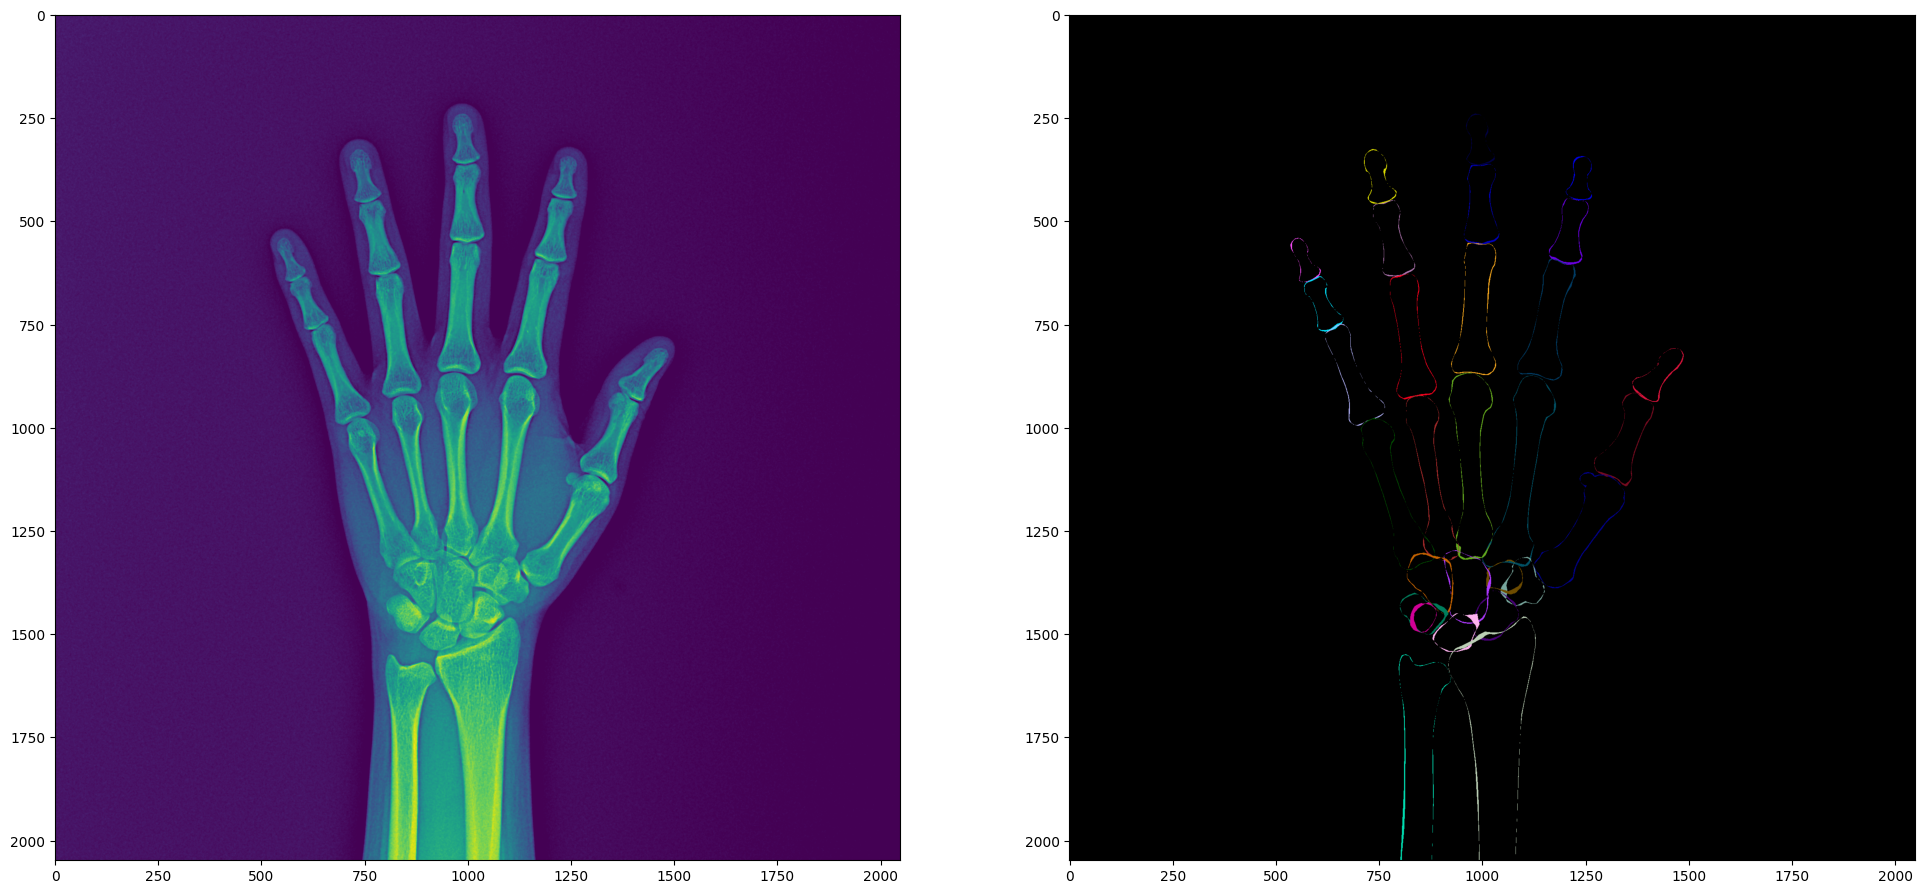

In [96]:
vis_val_comp(df,1)

In [102]:
def vis_val_comp_interpolation(df,idx,resize_shape=(512,512)):

    img_names = df['image_name'].unique()

    df_ = df[df['image_name']==img_names[idx]]

    image_path = df_['image_path'].iloc[0]
    
    image = cv2.imread(os.path.join(IMAGE_ROOT, image_path))
    image = image / 255.

    label_path = df_['label_path'].iloc[0]

    # (H, W, NC) 모양의 label을 생성합니다.
    label_shape = tuple(resize_shape) + (len(CLASSES), )
    label = np.zeros(label_shape, dtype=np.uint8)
    print(label.shape)
    # label 파일을 읽습니다.
    with open(os.path.join(LABEL_ROOT, label_path), "r") as f:
        annotations = json.load(f)
    annotations = annotations["annotations"]

    # 클래스 별로 처리합니다.
    for ann in annotations:
        c = ann["label"]
        class_ind = CLASS2IND[c]
        points = np.array(ann["points"])
        
        # polygon 포맷을 dense한 mask 포맷으로 바꿉니다.
        class_label = np.zeros(image.shape[:2], dtype=np.uint8)
        cv2.fillPoly(class_label, [points], 1)
        
        
        matching_rows = df_[df_['class'] == c]
        for _, row in matching_rows.iterrows():
            rle = row['rle']
            mask = rle_to_mask(rle, image.shape[0], image.shape[1])
            
            class_label = cv2.resize(class_label, resize_shape, interpolation=cv2.INTER_LINEAR)
            mask = cv2.resize(mask, resize_shape, interpolation=cv2.INTER_LINEAR)


            difference_mask = (mask != class_label).astype(np.uint8)

            label[..., class_ind] = difference_mask

    # to tenser will be done later
    image = image.transpose(2, 0, 1)    # channel first 포맷으로 변경합니다.
    label = label.transpose(2, 0, 1)

    image = torch.from_numpy(image).float()
    label = torch.from_numpy(label).float()
    
    fig, ax = plt.subplots(1, 2, figsize=(24, 12))
    ax[0].imshow(image[0])    # color map 적용을 위해 channel 차원을 생략합니다.
    ax[1].imshow(label2rgb(label))

    plt.show()
    # return image, label

(512, 512, 29)


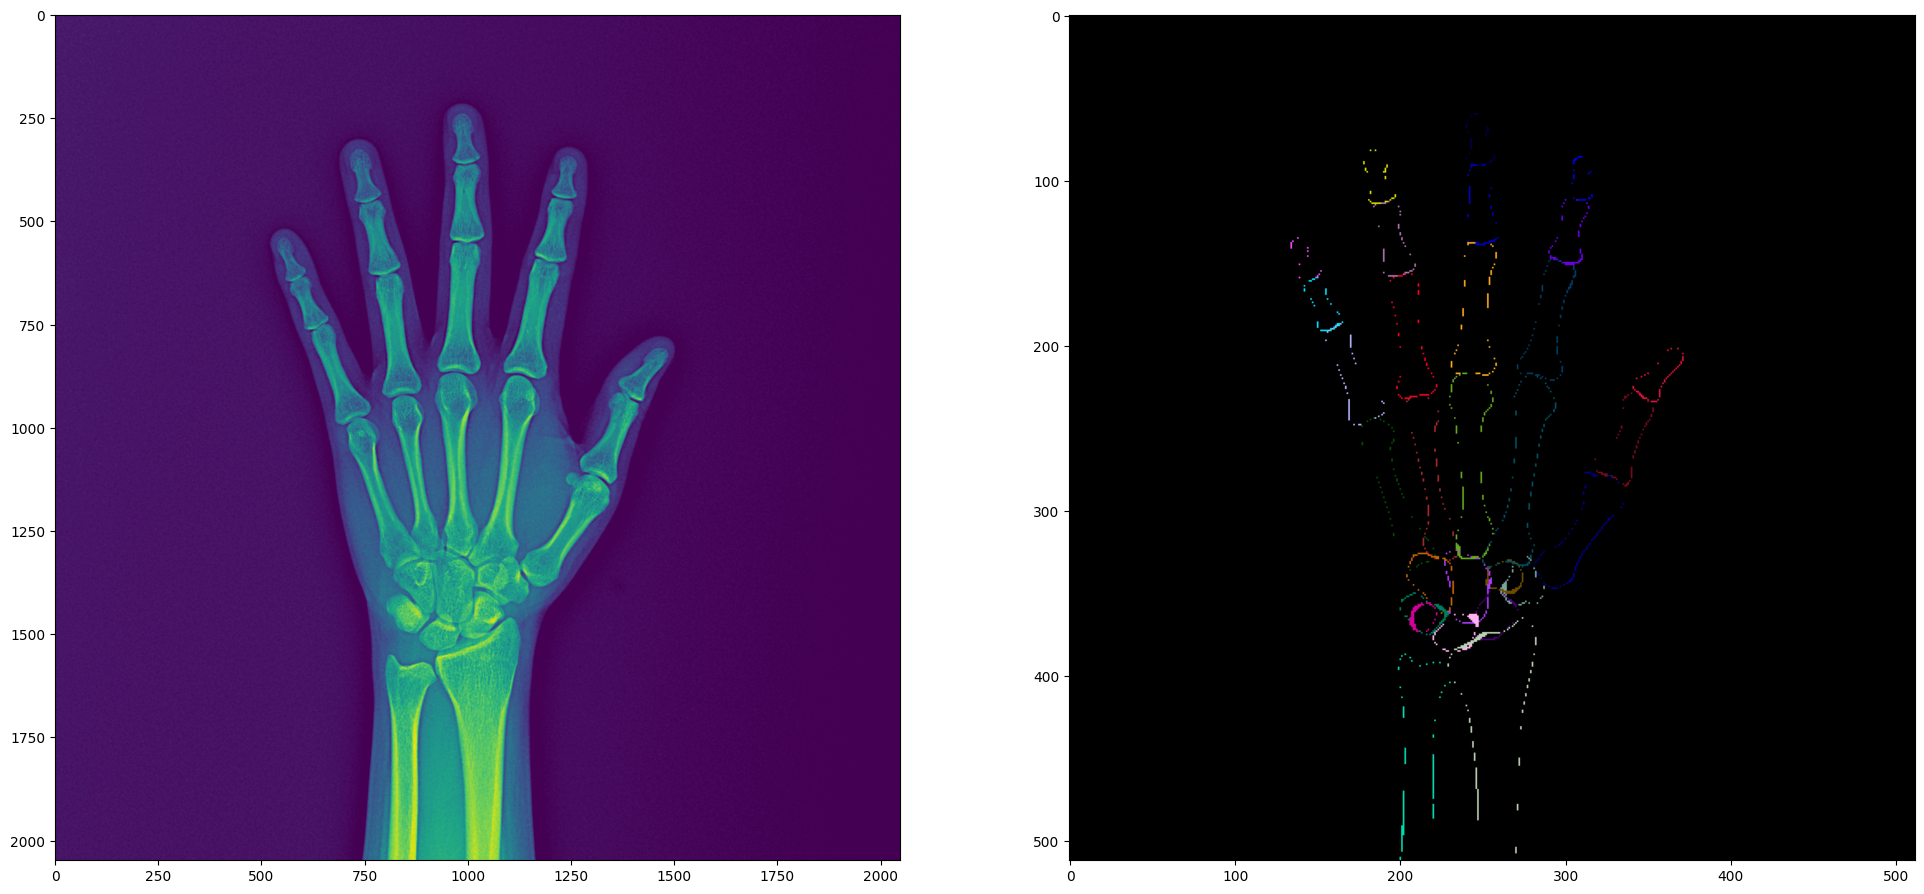

In [103]:
vis_val_comp_interpolation(df,1)